In [1]:
import os
import warnings
from pprint import pprint
from glob import glob
from tqdm import tqdm
from dotenv import load_dotenv
load_dotenv(verbose=True)

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as T
import tempfile
from box import Box
from timm import create_model
from sklearn.model_selection import StratifiedKFold
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image

import pytorch_lightning as pl
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning import callbacks
from pytorch_lightning.callbacks.progress import ProgressBarBase
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import MLFlowLogger
from pytorch_lightning import LightningDataModule, LightningModule

warnings.filterwarnings("ignore")

## config

In [2]:
config = {'seed': 2021,
          'root': '../input/petfinder-pawpularity-score/', 
          'n_splits': 2,
          'epoch': 2,
          'trainer': {
              'gpus': 1,
              'accumulate_grad_batches': 1,
              'fast_dev_run': False,
              'num_sanity_val_steps': 0,
              'resume_from_checkpoint': None,
          },
          'transform':{
              'name': 'get_default_transforms',
              'image_size': 224
          },
          'train_loader':{
              'batch_size': 8,
              'shuffle': True,
              'num_workers': 4,
              'pin_memory': False,
              'drop_last': True,
          },
          'val_loader': {
              'batch_size': 8,
              'shuffle': False,
              'num_workers': 4,
              'pin_memory': False,
              'drop_last': False
         },
          'model':{
              'name': 'resnet34',
              'output_dim': 1
          },
          'optimizer':{
              'name': 'optim.AdamW',
              'params':{
                  'lr': 1e-5
              },
          },
          'scheduler':{
              'name': 'optim.lr_scheduler.CosineAnnealingWarmRestarts',
              'params':{
                  'T_0': 20,
                  'eta_min': 1e-4,
              }
          },
          'loss': 'nn.BCEWithLogitsLoss',
}

config = Box(config)

In [3]:
pprint(config)

{'epoch': 2,
 'loss': 'nn.BCEWithLogitsLoss',
 'model': <Box: {'name': 'resnet34', 'output_dim': 1}>,
 'n_splits': 2,
 'optimizer': <Box: {'name': 'optim.AdamW', 'params': {'lr': 1e-05}}>,
 'root': '../input/petfinder-pawpularity-score/',
 'scheduler': {'name': 'optim.lr_scheduler.CosineAnnealingWarmRestarts',
               'params': <Box: {'T_0': 20, 'eta_min': 0.0001}>},
 'seed': 2021,
 'train_loader': {'batch_size': 8,
                  'drop_last': True,
                  'num_workers': 4,
                  'pin_memory': False,
                  'shuffle': True},
 'trainer': {'accumulate_grad_batches': 1,
             'fast_dev_run': False,
             'gpus': 1,
             'num_sanity_val_steps': 0,
             'resume_from_checkpoint': None},
 'transform': <Box: {'name': 'get_default_transforms', 'image_size': 224}>,
 'val_loader': {'batch_size': 8,
                'drop_last': False,
                'num_workers': 4,
                'pin_memory': False,
                'shu

## dataset

In [4]:
class PetfinderDataset(Dataset):
    def __init__(self, df, image_size=224):
        self._X = df["Id"].values
        self._y = None
        if "Pawpularity" in df.keys():
            self._y = df["Pawpularity"].values
        self._transform = T.Resize([image_size, image_size])

    def __len__(self):
        return len(self._X)

    def __getitem__(self, idx):
        image_path = self._X[idx]
        image = read_image(image_path)
        image = self._transform(image)
        if self._y is not None:
            label = self._y[idx]
            return image, label
        return image

class PetfinderDataModule(LightningDataModule):
    def __init__(
        self,
        train_df,
        val_df,
        cfg,
    ):
        super().__init__()
        self._train_df = train_df
        self._val_df = val_df
        self._cfg = cfg

    def __create_dataset(self, train=True):
        return (
            PetfinderDataset(self._train_df, self._cfg.transform.image_size)
            if train
            else PetfinderDataset(self._val_df, self._cfg.transform.image_size)
        )

    def train_dataloader(self):
        dataset = self.__create_dataset(True)
        return DataLoader(dataset, **self._cfg.train_loader)

    def val_dataloader(self):
        dataset = self.__create_dataset(False)
        return DataLoader(dataset, **self._cfg.val_loader)

## visualize data

In [5]:
torch.autograd.set_detect_anomaly(True)
seed_everything(config.seed)

df = pd.read_csv(os.path.join(config.root, "train.csv"))
df["Id"] = df["Id"].apply(lambda x: os.path.join(config.root, "train", x + ".jpg"))
df = df.head(200)

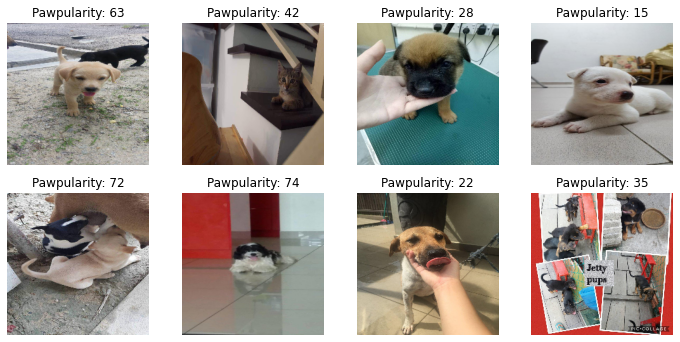

In [6]:
sample_dataloader = PetfinderDataModule(df, df, config).val_dataloader()
images, labels = iter(sample_dataloader).next()

plt.figure(figsize=(12, 12))
for it, (image, label) in enumerate(zip(images[:16], labels[:16])):
    plt.subplot(4, 4, it+1)
    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')
    plt.title(f'Pawpularity: {int(label)}')

## augmentation

In [7]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]  # RGB
IMAGENET_STD = [0.229, 0.224, 0.225]  # RGB


def get_default_transforms():
    transform = {
        "train": T.Compose(
            [
                T.RandomHorizontalFlip(),
                T.RandomVerticalFlip(),
                T.RandomAffine(15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
                T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
                T.ConvertImageDtype(torch.float),
                T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
            ]
        ),
        "val": T.Compose(
            [
                T.ConvertImageDtype(torch.float),
                T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
            ]
        ),
    }
    return transform


## model

In [8]:
def mixup(x: torch.Tensor, y: torch.Tensor, alpha: float = 1.0):
    assert alpha > 0, "alpha should be larger than 0"
    assert x.size(0) > 1, "Mixup cannot be applied to a single instance."

    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(x.size()[0])
    mixed_x = lam * x + (1 - lam) * x[rand_index, :]
    target_a, target_b = y, y[rand_index]
    return mixed_x, target_a, target_b, lam

class Model(pl.LightningModule):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.__build_model()
        self._criterion = eval(self.cfg.loss)()
        self.transform = get_default_transforms()
        self.save_hyperparameters(cfg)

    def __build_model(self):
        self.backbone = create_model(
            self.cfg.model.name, pretrained=True, num_classes=0, in_chans=3
        )
        num_features = self.backbone.num_features
        self.fc = nn.Sequential(
            nn.Dropout(0.5), nn.Linear(num_features, self.cfg.model.output_dim)
        )

    def forward(self, x):
        f = self.backbone(x)
        out = self.fc(f)
        return out

    def training_step(self, batch, batch_idx):
        loss, pred, labels = self.__share_step(batch, 'train')
        return {'loss': loss, 'pred': pred, 'labels': labels}
        
    def validation_step(self, batch, batch_idx):
        loss, pred, labels = self.__share_step(batch, 'val')
        return {'pred': pred, 'labels': labels}
    
    def __share_step(self, batch, mode):
        images, labels = batch
        labels = labels.float() / 100.0
        images = self.transform[mode](images)
        
        if torch.rand(1)[0] < 0.5 and mode == 'train':
            mix_images, target_a, target_b, lam = mixup(images, labels, alpha=0.5)
            logits = self.forward(mix_images).squeeze(1)
            loss = self._criterion(logits, target_a) * lam + \
                (1 - lam) * self._criterion(logits, target_b)
        else:
            logits = self.forward(images).squeeze(1)
            loss = self._criterion(logits, labels)
        
        pred = logits.sigmoid().detach().cpu() * 100.
        labels = labels.detach().cpu() * 100.
        return loss, pred, labels
        
    def training_epoch_end(self, outputs):
        self.__share_epoch_end(outputs, 'train')

    def validation_epoch_end(self, outputs):
        self.__share_epoch_end(outputs, 'val')    
        
    def __share_epoch_end(self, outputs, mode):
        preds = []
        labels = []
        for out in outputs:
            pred, label = out['pred'], out['labels']
            preds.append(pred)
            labels.append(label)
        preds = torch.cat(preds)
        labels = torch.cat(labels)
        metrics = torch.sqrt(((labels - preds) ** 2).mean())
        self.log(f'{mode}_loss', metrics, on_epoch=True)
    
    def check_gradcam(self, dataloader, target_layer, target_category):
        cam = GradCAMPlusPlus(
            model=self,
            target_layer=target_layer, 
            use_cuda=self.cfg.trainer.gpus)
        
        org_images, labels = iter(dataloader).next()
        cam.batch_size = len(org_images)
        images = self.transform['val'](org_images)
        images = images.to(self.device)
        logits = self.forward(images).squeeze(1)
        pred = logits.sigmoid().detach().cpu().numpy() * 100
        labels = labels.cpu().numpy()
        
        grayscale_cam = cam(input_tensor=images, target_category=target_category, eigen_smooth=True)
        org_images = org_images.detach().cpu().numpy().transpose(0, 2, 3, 1) / 255.
        return org_images, grayscale_cam, pred, labels

    def configure_optimizers(self):
        optimizer = eval(self.cfg.optimizer.name)(
            self.parameters(), **self.cfg.optimizer.params
        )
        scheduler = eval(self.cfg.scheduler.name)(
            optimizer,
            **self.cfg.scheduler.params
        )
        return [optimizer], [scheduler]

## train

In [9]:
def save_gradcam_figure(output_path, images, grayscale_cams, preds, labels):
    plt.figure(figsize=(12, 12))
    for it, (image, grayscale_cam, pred, label) in enumerate(zip(images, grayscale_cams, preds, labels)):
        plt.subplot(4, 4, it + 1)
        visualization = show_cam_on_image(image, grayscale_cam)
        plt.imshow(visualization)
        plt.title(f'pred: {pred:.1f} label: {label}')
        plt.axis('off')
    plt.savefig(output_path)
    
def get_now_time(output_format='%Y%m%d%H%M%S'):
    import datetime
    now = datetime.datetime.now()
    output_time = now.strftime(output_format)
    return output_time


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

2022/12/08 09:27:41 WARNING mlflow.utils.requirements_utils: Found torch version (1.11.0+cu113) contains a local version label (+cu113). MLflow logged a pip requirement for this package as 'torch==1.11.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

2022/12/08 09:29:02 WARNING mlflow.utils.requirements_utils: Found torch version (1.11.0+cu113) contains a local version label (+cu113). MLflow logged a pip requirement for this package as 'torch==1.11.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


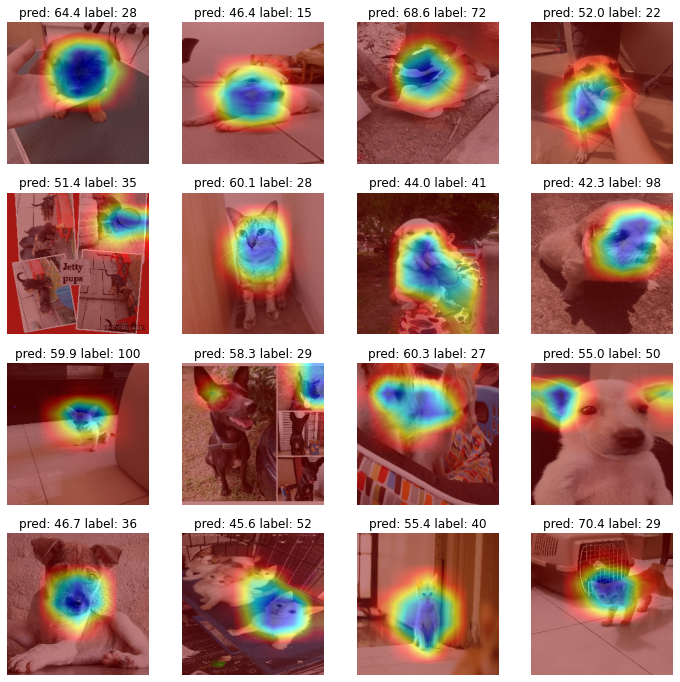

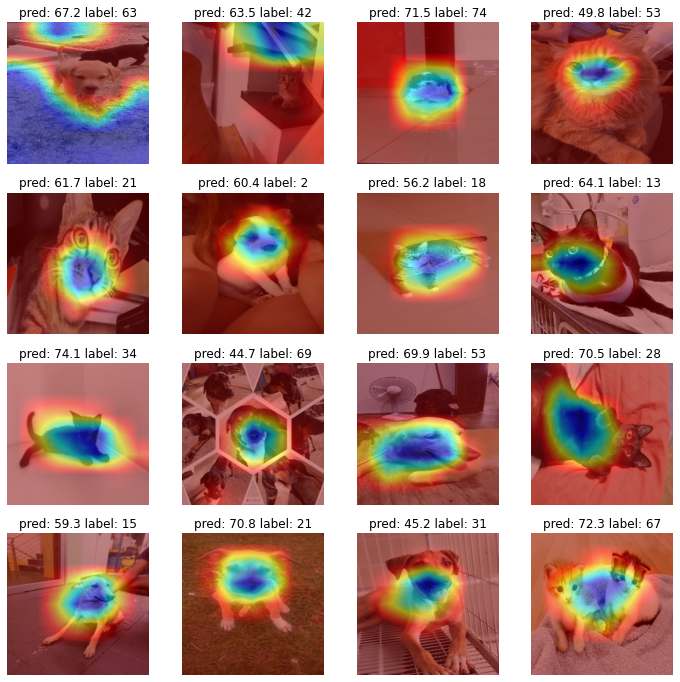

In [10]:
import mlflow

skf = StratifiedKFold(
    n_splits=config.n_splits, shuffle=True, random_state=config.seed
)

for fold, (train_idx, val_idx) in enumerate(skf.split(df["Id"], df["Pawpularity"])):
    train_df = df.loc[train_idx].reset_index(drop=True)
    val_df = df.loc[val_idx].reset_index(drop=True)
    datamodule = PetfinderDataModule(train_df, val_df, config)
    model = Model(config)
    earystopping = EarlyStopping(monitor="val_loss")
    lr_monitor = callbacks.LearningRateMonitor()
    
    now_time = get_now_time()
    MLFLOW_EXPERIMENT_NAME = 'laboticgate_petfinder2'
    mlflow.set_tracking_uri(os.environ['MLFLOW_TRACKING_URI'])
    experiment = mlflow.get_experiment_by_name(MLFLOW_EXPERIMENT_NAME)
    exp_id = experiment.experiment_id if experiment else mlflow.create_experiment(MLFLOW_EXPERIMENT_NAME)
    run_name = f'{now_time}_{MLFLOW_EXPERIMENT_NAME}_fold{fold}'

    output_model_path = f'../output/{MLFLOW_EXPERIMENT_NAME}'
    os.makedirs(output_model_path, exist_ok=True)
    
    loss_checkpoint_filename = f"best_loss_fold{fold}"
    loss_checkpoint = callbacks.ModelCheckpoint(
        dirpath=output_model_path,
        filename=loss_checkpoint_filename,
        monitor="val_loss",
        save_top_k=1,
        mode="min",
        save_last=False,
    )
    
    
    with mlflow.start_run(experiment_id=exp_id, run_name=run_name) as run:
        run_id = run.info.run_id
        mlflow_logger = MLFlowLogger(experiment_name=MLFLOW_EXPERIMENT_NAME,
                              tracking_uri=os.environ['MLFLOW_TRACKING_URI'])
        mlflow_logger._run_id = run_id

        trainer = pl.Trainer(
            logger=mlflow_logger,
            max_epochs=config.epoch,
            callbacks=[lr_monitor, loss_checkpoint, earystopping],
            **config.trainer,
        )
        trainer.fit(model, datamodule=datamodule)
        mlflow.log_artifact(os.path.join(output_model_path, loss_checkpoint_filename+'.ckpt'))
        mlflow.pytorch.log_model(model, "model")
        
        #gradcam
        config.val_loader.batch_size = 16
        datamodule = PetfinderDataModule(train_df, val_df, config)
        images, grayscale_cams, preds, labels = model.check_gradcam(
                                                    datamodule.val_dataloader(), 
                                                    target_layer=model.backbone.layer4[-1],
                                                    target_category=None)
        
        temp_dir = tempfile.TemporaryDirectory() 
        output_figure_path = os.path.join(temp_dir.name, f"predict_results.png")
        save_gradcam_figure(output_figure_path, images, grayscale_cams, preds, labels)
        mlflow.log_artifact(output_figure_path)

mlflowに保存したmodelを読み込みたい場合はここを参照  
https://www.mlflow.org/docs/latest/python_api/mlflow.pytorch.html#mlflow.pytorch.load_state_dict